# Pb from BC parameterization (Villum)

Villum (Northern Greenland)

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import numpy
import pandas as pd
import datetime
from matplotlib.dates import date2num, num2date
import matplotlib.dates as mdates
import calendar
import seaborn as sns
from scipy.optimize import leastsq
from scipy.stats import pearsonr, spearmanr
import xarray as xr

%matplotlib inline

In [2]:
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

In [104]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    """

    if x.ndim != 1:
        raise ValueError#, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError#, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError#, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [4]:
def lin_fit(x, y):
    '''Fits a linear fit of the form mx+b to the data'''
    fitfunc = lambda params, x: params[0] * x  
    errfunc = lambda p, x, y: fitfunc(p, x) - y              #create error function for least squares fit

    init_a = 0.5                            #find initial value for a (gradient)
    init_p = np.array((init_a))  #bundle initial values in initial parameters

    #calculate best fitting parameters (i.e. ) using the error function
    p1, success = leastsq(errfunc, init_p.copy(), args = (x, y))
    f = fitfunc(p1, x)          #create a fit with those parameters
    return p1, f  

## Load data from Villum

Black carbon is from May 2011 to August 2013, while Pb goes from 1990-2015

In [5]:
Pb = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Analysis_data_LW_Fly_keld_master_report_SE_out_PB_BC.csv').dropna(subset=['Pb_PIXEICPMS'])
Pb['Date_BASE'] = pd.to_datetime(Pb.Date_BASE[2:])
Pb       = Pb.sort_values(by='Date_BASE')
dates_Pb = Pb['Date_BASE'][2:]
conc_Pb  = Pb['Pb_PIXEICPMS'][2:] #ng/m3

In [6]:
# Data source: "Atmospheric black carbon and sulfate concentrations in Northeast Greenland", Andreas Massling
BC = pd.read_csv('/ocean/brogalla/GEOTRACES/data/MAAP_24h_Birgit_final.csv')
BC['Date'] = pd.to_datetime(BC.Date)
BC       = BC.sort_values(by='Date')
dates_BC = pd.to_datetime(BC['Date'])
conc_BC  = BC['AvgOf24hconc'] #ng/m3

### Identify indices of period of overlap:

In [7]:
print('BC: ', dates_BC.iloc[0],'   ', dates_BC.iloc[-1])
print('Pb: ', dates_Pb.iloc[0],'   ', dates_Pb.iloc[-3])

BC:  2011-05-14 00:00:00     2013-08-23 00:00:00
Pb:  1990-05-11 00:00:00     2015-12-28 00:00:00


In [8]:
indx = np.array([])

for ind in range(702,799):
    # Find index of nearest BC date for each Pb measurement:
    indx_add = np.abs(dates_BC - dates_Pb.iloc[ind]).idxmin()
    indx     = np.append(indx, indx_add)

In [97]:
dates_Pb_overlap = np.array(dates_Pb.iloc[702:799])
conc_Pb_overlap  = np.array(conc_Pb.iloc[702:799].astype(float))
dates_BC_overlap = np.array(dates_BC[indx])
conc_BC_overlap  = np.array(conc_BC[indx].astype(float))

### Look at these overlapping time periods:

In [20]:
months = mdates.MonthLocator()  # every month

(734271.0, 735103.0)

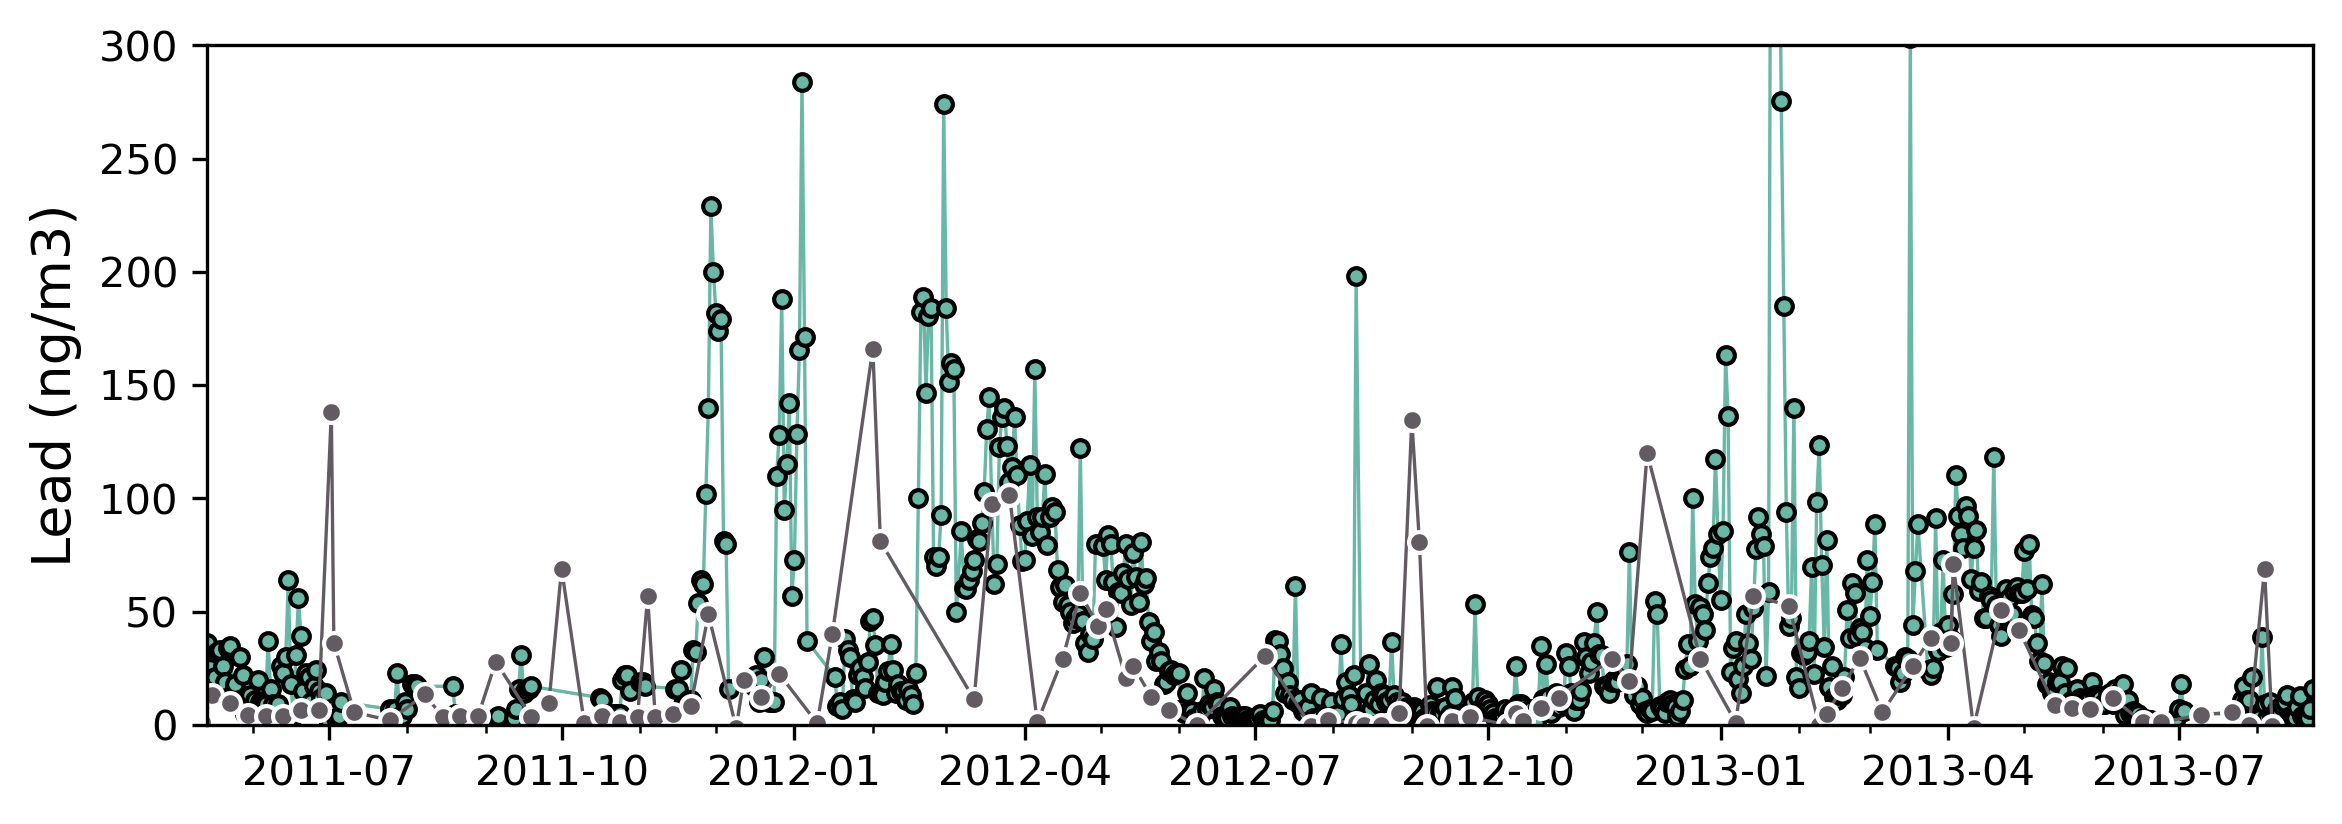

In [98]:
fig, ax1 = plt.subplots(1,1, figsize=(9.055, 3.0), dpi=300)
ax1.plot_date(dates_BC, conc_BC,'.-', color='#67b8a5', markersize=8, markeredgecolor='k', linewidth=0.8)
ax1.plot_date(dates_Pb_overlap, conc_Pb_overlap*100,'.-', color='#625b62', markersize=10, markeredgecolor='w', linewidth=0.8)
ax1.set_ylabel('Lead (ng/m3)', fontsize=13)
ax1.xaxis.set_minor_locator(months)
ax1.set_ylim([0, 300])
ax1.set_xlim([dates_BC.iloc[0], dates_BC.iloc[-1]])

In [114]:
# Monthly smoothing:
Pb_ave_overlap = smooth(conc_Pb_overlap, window_len=5, window='hanning')[2:-2]
BC_ave_overlap = smooth(conc_BC_overlap, window_len=15, window='hanning')[7:-7]
# BC_ave_overlap = [BC_ave[int(x)] for x in indx]

In [115]:
print(len(dates_BC_overlap), BC_ave_overlap.shape)
print(len(dates_Pb_overlap), Pb_ave_overlap.shape)

97 (97,)
97 (97,)


(734271.0, 735087.0)

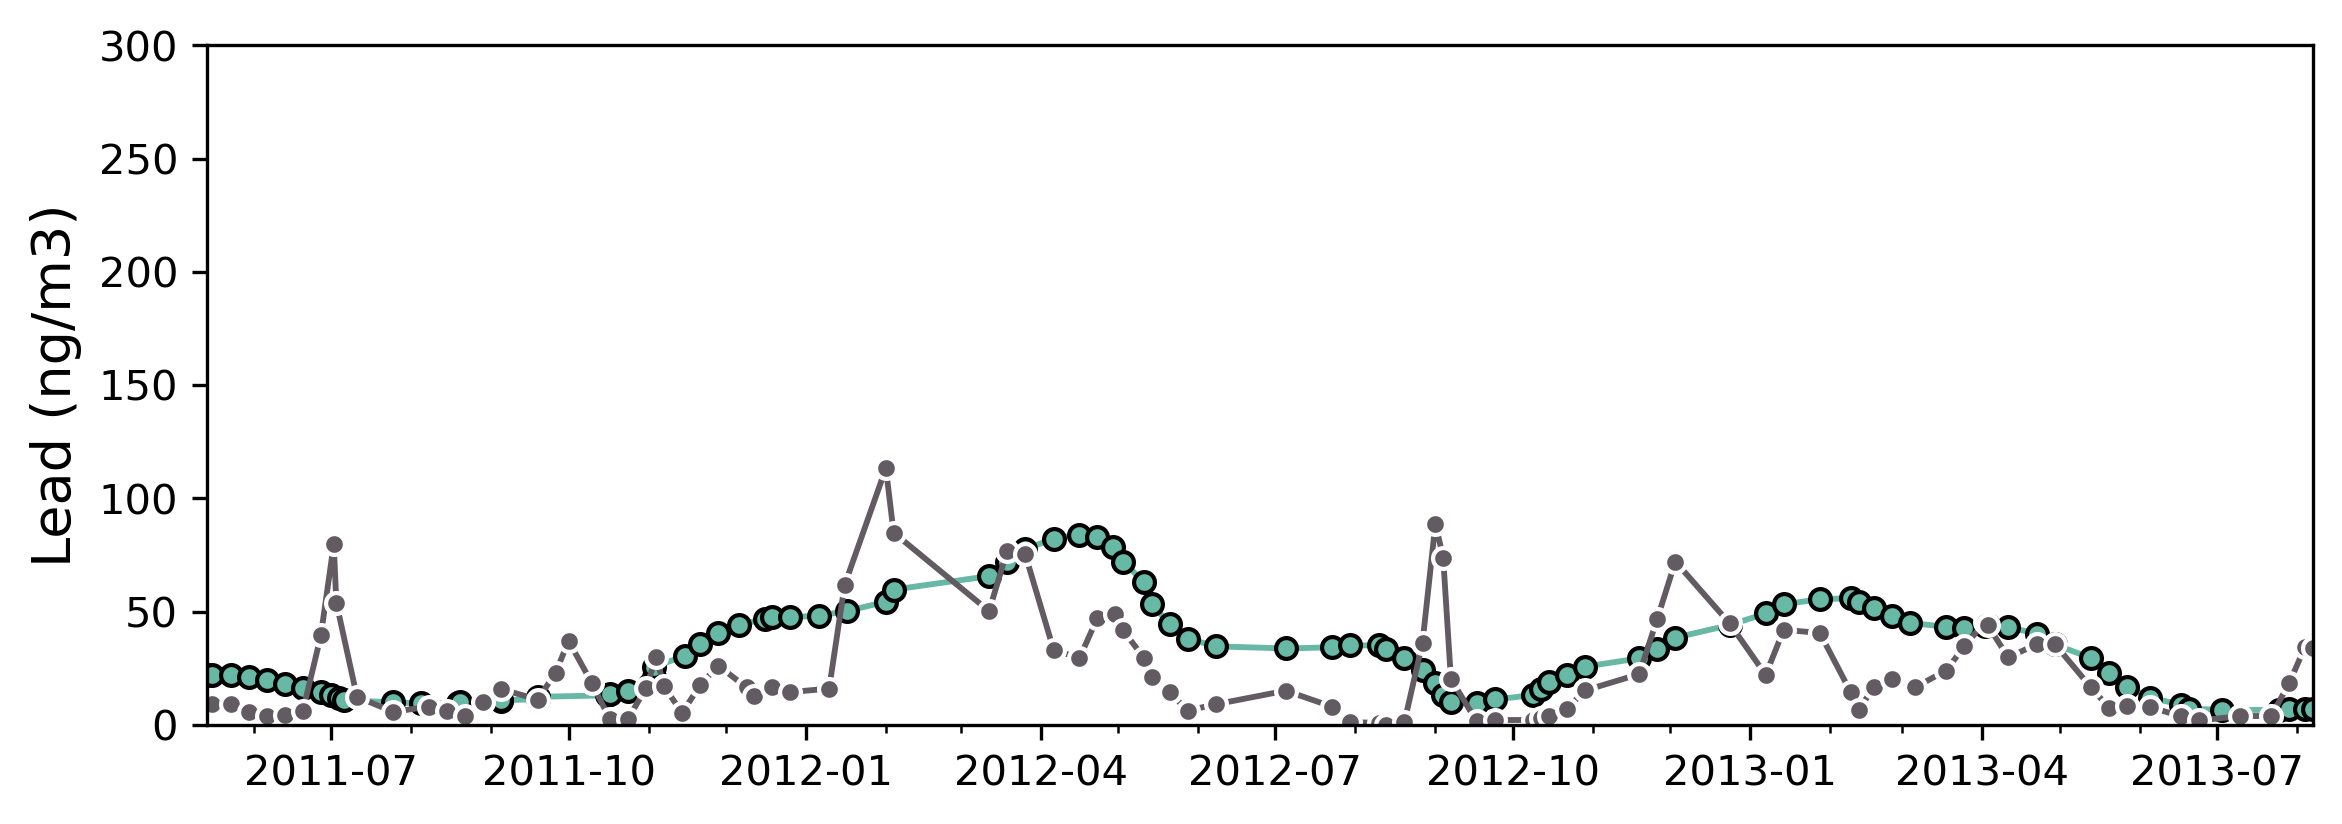

In [116]:
fig, ax1 = plt.subplots(1,1, figsize=(9.055, 3.0), dpi=300)
ax1.plot_date(dates_BC_overlap, BC_ave_overlap,'.-', color='#67b8a5', markersize=10, markeredgecolor='k', linewidth=1.4)
ax1.plot_date(dates_Pb_overlap, Pb_ave_overlap*100,'.-', color='#625b62', markersize=10, markeredgecolor='w', linewidth=1.4)
ax1.set_ylabel('Lead (ng/m3)', fontsize=13)
ax1.xaxis.set_minor_locator(months)
ax1.set_ylim([0, 300])
ax1.set_xlim([dates_BC_overlap[0], dates_BC_overlap[-1]])

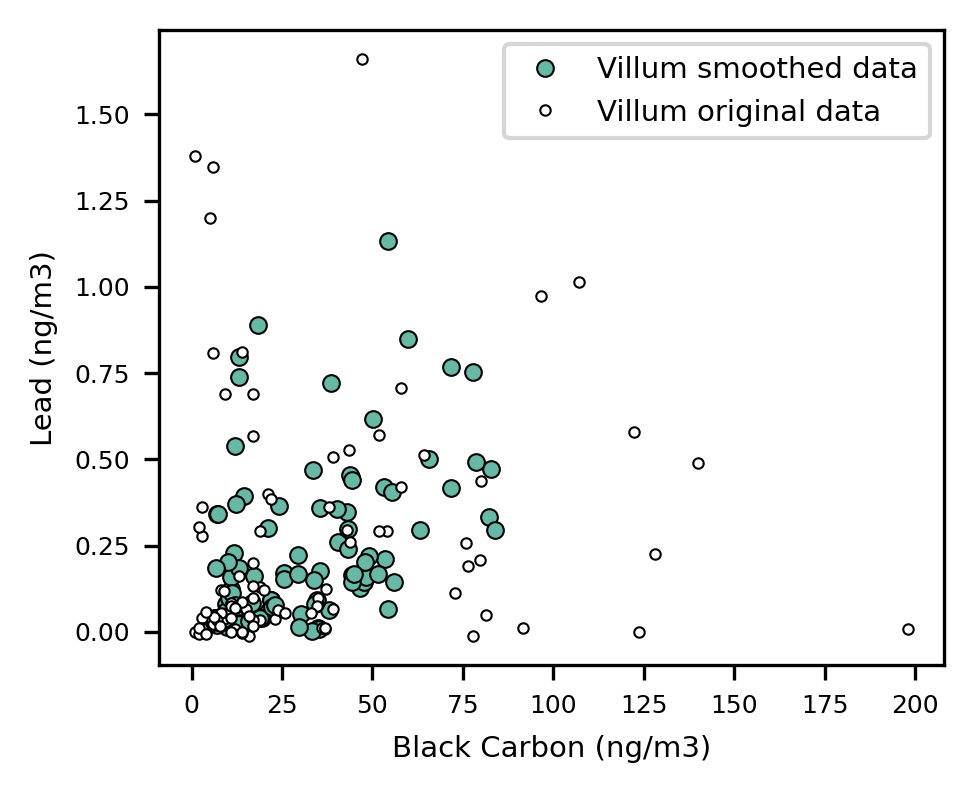

In [144]:
scale = 0.75
fig, ax1 = plt.subplots(1,1, figsize=(4.5*scale, 3.74*scale), dpi=300)
ax1.plot(BC_ave_overlap, Pb_ave_overlap, '.', color='#67b8a5', markersize=8, markeredgecolor='k', markeredgewidth=0.5, label='Villum smoothed data')
ax1.plot(conc_BC_overlap, conc_Pb_overlap, '.w', markersize=5, markeredgecolor='k', markeredgewidth=0.5, label='Villum original data')
ax1.set_ylabel('Lead (ng/m3)', fontsize=7)
ax1.set_xlabel('Black Carbon (ng/m3)', fontsize=7)
ax1.tick_params(axis='both', labelsize=6)
ax1.legend(fontsize=7)
# ax1.set_xlim([-1, 100])
# ax1.set_ylim([-3, 100])

In [15]:
print('Pearson r value: '+ str(pearsonr(conc_BC_overlap, conc_Pb_overlap)))
print('Spearman r value: '+ str(spearmanr(conc_BC_overlap, conc_Pb_overlap))) # rank correlation

Pearson r value: (0.14522113112080556, 0.1558242356471404)
Spearman r value: SpearmanrResult(correlation=0.29388549237763145, pvalue=0.0034809995338307698)


In [145]:
print('Pearson r value: '+ str(pearsonr(BC_ave_overlap, Pb_ave_overlap)))
print('Spearman r value: '+ str(spearmanr(BC_ave_overlap, Pb_ave_overlap))) # rank correlation

Pearson r value: (0.4197059238389408, 1.87410604052498e-05)
Spearman r value: SpearmanrResult(correlation=0.4585919419314117, pvalue=2.313832635231019e-06)


Let's instead create smooth fits of black carbon and Pb and interpolate values:

In [13]:
Pb_smooth = smooth(conc_Pb_overlap, window_len=20, window='flat')
BC_smooth = smooth(conc_BC, window_len=20, window='flat')

In [14]:
base = dates_BC.iloc[0]
diff = (dates_BC.iloc[-1] - base)
time_grid = [base + datetime.timedelta(days=4*x) for x in range(0, int(diff.days/4))] 

In [16]:
print(Pb_smooth.shape, BC_smooth.shape)

(116,) (690,)


In [15]:
t1_BC   = np.array([toTimestamp(t) for t in dates_BC])
t1_Pb   = np.array([toTimestamp(t) for t in dates_Pb.iloc[702:799]])
BC_int  = np.array(BC_smooth[9:680])
Pb_int  = np.array(Pb_smooth[2:103])

BC_grid = np.interp([toTimestamp(t) for t in time_grid], t1_BC, BC_int)
Pb_grid = np.interp([toTimestamp(t) for t in time_grid], t1_Pb, Pb_int)

ValueError: fp and xp are not of the same length.

In [ ]:
p1, f = lin_fit(BC_grid, Pb_grid*100)

In [ ]:
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.plot(BC_grid, Pb_grid*100, '.', markersize=12)
ax1.plot(BC_grid, f, 'r')
ax1.set_xlabel('Black Carbon', fontsize=14)
ax1.set_ylabel('Pb', fontsize=14)
ax1.set_xlim([-1, 200])
# ax1.set_ylim([-3, 100])

In [164]:
print('Pearson r value: '+ str(pearsonr(BC_grid, Pb_grid)))
print('Spearman r value: '+ str(spearmanr(BC_grid, Pb_grid))) # rank correlation

Pearson r value: (0.42580195682501, 1.437994825655271e-10)
Spearman r value: SpearmanrResult(correlation=0.5655377432809767, pvalue=5.585871126410835e-19)


(-5, 250)

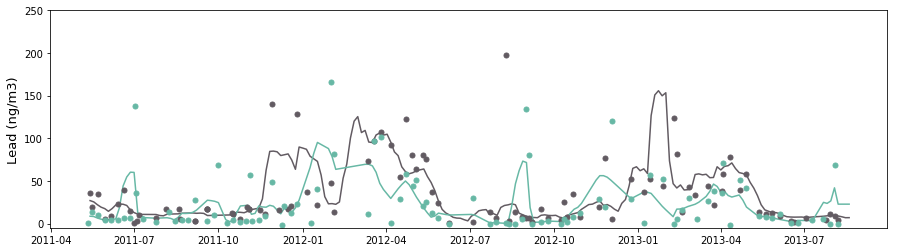

In [149]:
fig,ax1 = plt.subplots(figsize=(15,4))
ax1.plot_date(time_grid, BC_grid,'-', color='#625b62')
ax1.plot_date(time_grid, Pb_grid*100,'-', color='#67b8a5')
ax1.plot_date(dates_BC_overlap, conc_BC_overlap,'.', color='#625b62', markersize=10)
ax1.plot_date(dates_Pb_overlap, conc_Pb_overlap*100,'.', color='#67b8a5', markersize=10)
ax1.set_ylabel('Lead (ng/m3)', fontsize=13)
ax1.set_ylim([-5, 250])